# `Modeling Drivers`<br>
### Baseline, Hypothesis testing for feature selection and model improvement

In this notebook, we want to assess how well our model perform to predict the inrjury level for drivers. Will will improve the model by adding hypothesis testing for feature selection and try to improve our score

For this classification tasks, we have selected the following models

1. Logistic Regression
2. Ada Boost
3. XG Boost
4. Linear Support Vectors (SVCs)

In [1]:
#Importing data manipulation and visualization libraries
import pandas as pd # for dataframe manipulation
import numpy as np # for numbers manipulations


import seaborn as sns # for data visualization
import matplotlib.pyplot as plt # for data visualization
import scipy.stats as stats # # we never just "import scipy" as all the juice is in the submodules

import plotly.express as px # for data visualization
import plotly.figure_factory as ff# for data visualization

from sklearn.preprocessing import LabelEncoder,FunctionTransformer,StandardScaler #for data preprocessing and scaling
from sklearn.feature_selection import chi2 #for hypothesis testing on categorical variables
from sklearn.pipeline import Pipeline #for chaining operations prior to the gridsearch

from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV #for modeling preparation

#importing our models
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC, LinearSVC
from xgboost import XGBClassifier, plot_importance

#importing metrics to evaluate models performance
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import  precision_score, recall_score, roc_auc_score, accuracy_score,f1_score,confusion_matrix,ConfusionMatrixDisplay, RocCurveDisplay, plot_roc_curve 
from imblearn.metrics import specificity_score

import warnings
warnings.filterwarnings("ignore")

# to access AWS
import aws_creds
import os
from smart_open import smart_open
import boto3 
from io import StringIO # python3; python2: BytesIO 

#check time it takes to run the entire notebook
import time
st = time.time()

Helper functions

In [2]:
#this function will fit models and generate visualization
def meta_func (model,model_name,param_grid,X_train,y_train,X_test,y_test,score_dict):
        #model
        gs_model = GridSearchCV(
        model,
        param_grid=param_grid,
        cv=3,
        verbose=1,
        n_jobs=-1
        )

        #fitting model -------------------------------------------------------
        gs_model.fit(X_train,y_train)

        #getting predictions
        train_preds = gs_model.predict(X_train)
        preds = gs_model.predict(X_test)
        
        #getting the test metrics ready
        test_f1score=f1_score(y_test,preds)
        test_precision=precision_score(y_test,preds)
        test_accuracy=accuracy_score(y_test,preds)
        test_recall=recall_score(y_test,preds)
        test_roc_auc=roc_auc_score(y_test,preds)
        test_specificity = specificity_score(y_test,preds)

        #getting the train metrics
        train_f1score=f1_score(y_train,train_preds)
        train_specificity = specificity_score(y_train,train_preds)
        train_precision=precision_score(y_train,train_preds)
        train_accuracy=accuracy_score(y_train,train_preds)
        train_recall=recall_score(y_train,train_preds)
        train_roc_auc=roc_auc_score(y_train,train_preds)
        #printing results-----------------------------------------------------------------

        print(f'best params : {gs_model.best_params_}')

        print(f'Test_f1_score : {test_f1score}')
        print(f'Test_precision score : {test_precision}')
        print(f'Test_accuracy score : {test_accuracy}')
        print(f'Test_recall score : {test_recall}')
        print(f'Test_roc_auc score : {test_roc_auc}')
                
        # #update various metrics onto results list-------------------------------------------------------------
        score_dict[model_name] = {
                'Train_acc':train_accuracy,
                'Test_acc':test_accuracy,
                'Train_recall':train_recall,
                'Test_recall':test_recall,
                'Train_preci':train_precision,
                'Test_preci':test_precision,
                'Train_f1score':train_f1score,
                'Test_f1score':test_f1score,
                'Train_roc_auc':train_roc_auc,
                'Test_roc_auc':test_roc_auc,
                'Train_specificity': train_specificity,
                'Test_specificity':test_specificity
                }

        tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
        cm = confusion_matrix(y_test,preds)
        displ = ConfusionMatrixDisplay(cm)
        displ.plot();

        plot_roc_curve(gs_model.best_estimator_, X_test, y_test)
        plt.plot([0, 1], [0, 1],
        label='baseline', linestyle='--') # to simulate random guess 
        plt.legend();

        return gs_model

In [3]:
#Helper functions - showing dataframe quality
def df_quality (df):
    df_qual= pd.DataFrame(df.dtypes, columns={'dtypes'}) # creating a colum to display all data types
    df_qual['isna%'] = np.round((df.isna().sum()/len(df))*100,1) # creating new columns = to missing values %
    df_qual['isna']= df.isna().sum()
    df_qual['unique']=df.nunique() # creating new columns eq to missing values
    return df_qual.sort_values(by= 'isna%' , ascending=False)[:40] # sorting and shortlisting

In [4]:
#function to test for statistical significance, and chosing the right test depending on data distribution
#borrowed from Shilpa's github  -https://github.com/shilpaleo/employee_resignation_prediction/blob/main/notebook/Resignation%20Case%20Study.ipynb

def cont_stat_sig_test(df,col):
    # defining function for normality + statistical significance check
    # Step 1: normality test
    stat, p_value = stats.normaltest(df[col].values)
    
    # Step 2: filter series    
    df_ok = df[df['injury_level']=='OK'][col].values
    df_not_ok = df[df['injury_level']=='not_ok'][col].values
    
    # Step 3: determining appropriate statistical significance test based on normality
    if p_value>0.01:
        distribution = 'normal distribution'
        test = 'Anova test'
        stat, p_value = stats.f_oneway(df_ok, df_not_ok)
    
    else:
        distribution = 'non-normal distribution'
        test = 'KS test'
        stat, p_value = stats.ks_2samp(df_ok, df_not_ok)
    
    # Step 4: conclude on statistical significance
    if p_value>0.05:
        sig = 'not statistically significant'
    else:
        sig = 'statistically significant'

    print(f'{col} has {distribution}: running {test}. result: {sig}')
    return p_value


In [5]:
#dictionary to store our results
score_dict_drivers={}

### 1. Preping data for 1st run

Importing file

In [6]:
#importing our file from AWS
aws_key = aws_creds.aws_key
aws_secret = aws_creds.aws_secret

bucket_name = aws_creds.bucket
object_key = 'df_eda.csv'

path = 's3://{}:{}@{}/{}'.format(aws_key, aws_secret, bucket_name, object_key)

df = pd.read_csv(smart_open(path), index_col=[0]) # index_col=[0] to avoid unammed:0

In [7]:
df['injury_level'] = df['injury_level'].map({'OK':1,'not_ok':0}) #mapping target variable to binary
df_driv = df[(df['user_type']=='driver')]
df_driv['injury_level'].value_counts()

1    227065
0     45673
Name: injury_level, dtype: int64

In [8]:
df_quality (df_driv)

,dtypes,isna%,isna,unique
pedestrian_group,object,100.0,272738,0
pedestrian_loc,object,100.0,272738,0
pedestrian_action,object,100.0,272717,4
reserved_path,object,90.3,246257,2
fixed_obstacle_hurt,object,85.5,233286,15
infra_type,object,84.4,230157,9
safety_feat_2,object,44.0,120004,8
width_road_only,object,35.5,96780,216
journey_reason,object,26.6,72633,6
mobile_obstacle_hurt,object,18.6,50699,6


Let's clear the NaN before fitting models. Given the NaNs identified above and the information contained in the columns, we make the choice to cut any feature with more than 10% NaN

In [9]:
#Let's remove all 10% above NaN features
high_nans = [col for col in df_driv.columns if ((df_driv[col].isna().sum()/len(df)))>0.1]
df_driv = df_driv.drop(columns = high_nans)
print(f'after dropping high_nan features, shape is : {df_driv.shape}')

#then we drop any columns with NaNs remaining 
df_driv = df_driv.dropna()
print(f'after dropping high_nan and remaining nan, shape is: {df_driv.shape}')

#finally, we manually renmove these columns as they are either duplicates or strongly correlated to other features
driv_cols_todrop = [
    'acc_num', # not informative 
    'id_vehicule', #not informative
    #'seat', only valid for drivers and passengers
    'user_type',# already filtered on drivers + passengers
    'day',#duplicate with day of the week and month
    'year',# dropping year but keeping month for seasonality
    'lat',#duplicate with geo
    'long', #duplicate with geo
    'date',#duplicate with day of the week and Month - we do not need that much details
    'hhmm',#already captured in hh
    'YYYY-MM',#another date duplicate only used for EDA
    'country',#not informative
    'lane_num', #not informative and generate tons of columns when dummified.
    'max_speed_allowed', # we are going with speed_group instead
    'city',
    'age',
    'geo',
    'dob',
    'postal_address',
    'department_fr']

df_driv = df_driv.drop(columns = driv_cols_todrop)
print(f'after dropping duplicates, final shape is : {df_driv.shape}')

after dropping high_nan features, shape is : (272738, 48)
after dropping high_nan and remaining nan, shape is: (157870, 48)
after dropping duplicates, final shape is : (157870, 29)


In [10]:
df_quality(df_driv) # check

,dtypes,isna%,isna,unique
seat,object,0.0,0,2
road_surface,object,0.0,0,8
vehi_grp,object,0.0,0,3
speed_group,float64,0.0,0,7
event,object,0.0,0,12
hour,int64,0.0,0,24
day_of_week,object,0.0,0,7
collision_type,object,0.0,0,7
weather,object,0.0,0,9
crossing,object,0.0,0,5


In [11]:
#preparing our X and y
X = df_driv.drop(columns='injury_level')
y=df_driv['injury_level']

In [12]:
#encoding categorical variables
X = pd.get_dummies(X, columns=X.select_dtypes('object').columns, drop_first=True)
X_train,X_test,y_train,y_test = train_test_split(X,y, random_state=42, test_size=0.2, stratify=y)
print(X.shape)

(157870, 138)


### 2. Modeling

#### Logistic Regression

Fitting 3 folds for each of 4 candidates, totalling 12 fits
best params : {'lr__C': 0.2, 'lr__class_weight': 'balanced', 'lr__penalty': 'l2'}
Test_f1_score : 0.8581067182293166
Test_precision score : 0.955255324021067
Test_accuracy score : 0.7815291062266422
Test_recall score : 0.7788939094066246
Test_roc_auc score : 0.7875699995416856
CPU times: total: 22 s
Wall time: 1min 51s


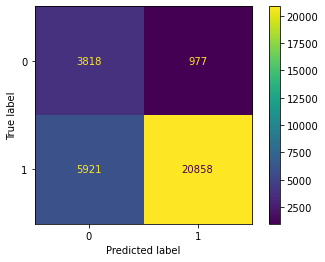

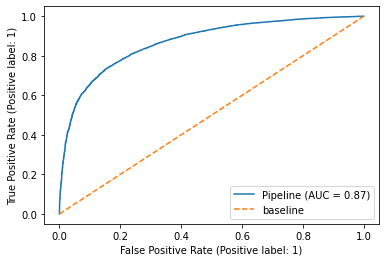

In [13]:
%%time
model = meta_func (
    model=
        Pipeline(
    [
    ('ss',StandardScaler()),
    ('lr', LogisticRegression(random_state=42, solver='saga'))
    ]
)
,
    model_name='lr_1st_round',
    param_grid=
    {"lr__penalty":['l1','l2'],
    "lr__C":[0.2,0.3],#Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization.
    "lr__class_weight":['balanced']     
    }
,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    score_dict= score_dict_drivers
)

In [14]:
#extract top features
pd_features = pd.DataFrame({'Features': X_train.columns,'Coef_': model.best_estimator_.steps[-1][1].coef_[0]})
pd_features.sort_values(by='Coef_', ascending=False)

,Features,Coef_
13,safety_feat_1_safety_belt,0.430395
59,was_doing_turning,0.331802
73,travelling_direction_unidirectional,0.269392
110,collision_type_three_or_more_vehicules_chain,0.238388
66,road_type_highway,0.224844
...,...,...
89,road_location_accident_others,-0.198967
10,safety_feat_1_helmet,-0.316653
96,in_out_city_out_of_city,-0.362933
91,road_location_accident_road_side,-0.385521


#### AdaBoost

Fitting 3 folds for each of 4 candidates, totalling 12 fits
best params : {'learning_rate': 1, 'n_estimators': 300}
Test_f1_score : 0.9283705601031723
Test_precision score : 0.8920826161790018
Test_accuracy score : 0.8733451574079939
Test_recall score : 0.9677359124687255
Test_roc_auc score : 0.6569649322510468
CPU times: total: 1min 32s
Wall time: 5min 3s


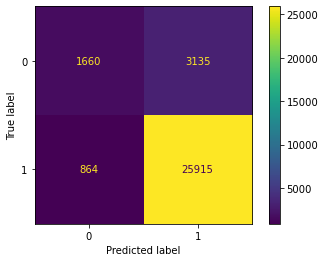

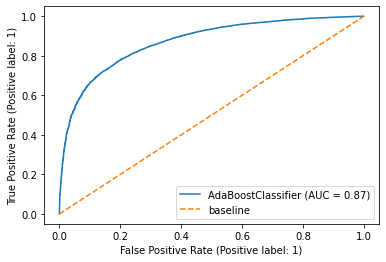

In [15]:
%%time
model = meta_func (
    model=AdaBoostClassifier(random_state=42)
,
    model_name='abc_1st_round',
    param_grid=
{
    'n_estimators': [150,300], 
    'learning_rate': [1, 2]
    }
,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    score_dict= score_dict_drivers
)

In [16]:
pd_features = pd.DataFrame({'Features': X_train.columns,'Coef_': model.best_estimator_.feature_importances_})
pd_features.sort_values(by='Coef_', ascending=False)

,Features,Coef_
3,hour,0.090000
90,road_location_accident_road,0.083333
4,speed_group,0.066667
91,road_location_accident_road_side,0.063333
1,num_operating_lanes,0.043333
...,...,...
71,road_type_urban_rd,0.000000
108,weather_snow,0.000000
44,was_doing_bus_lane_opp_direct,0.000000
111,collision_type_three_or_more_vehicules_multiple,0.000000


#### XGBoost

Fitting 3 folds for each of 8 candidates, totalling 24 fits
best params : {'learning_rate': 1, 'max_depth': 2, 'min_split_loss': 1}
Test_f1_score : 0.9302283729551712
Test_precision score : 0.8977699041267194
Test_accuracy score : 0.877209096091721
Test_recall score : 0.9651219238955898
Test_roc_auc score : 0.6756787930218303
CPU times: total: 1min 1s
Wall time: 3min 2s


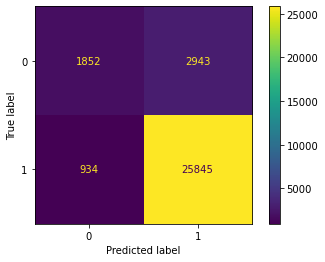

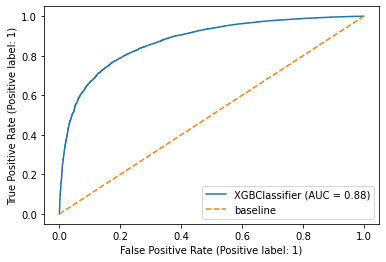

In [17]:
%%time
model = meta_func (
    model=XGBClassifier(random_state=42)
,
    model_name='xgb_1st_round',
    param_grid=
{
    'learning_rate': [0.5,1], 
    'min_split_loss': [1,2], #The larger gamma is, the more conservative the algorithm will be
    'max_depth':[2,3] #Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit.
     # Beware that XGBoost aggressively consumes memory when training a deep tree
    }
,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    score_dict= score_dict_drivers
)

In [18]:
pd_features = pd.DataFrame({'Features': X_train.columns,'Coef_': model.best_estimator_.feature_importances_})
pd_features.sort_values(by='Coef_', ascending=False)

,Features,Coef_
13,safety_feat_1_safety_belt,0.225316
69,road_type_regional_rd,0.095567
66,road_type_highway,0.075080
96,in_out_city_out_of_city,0.056309
91,road_location_accident_road_side,0.050669
...,...,...
51,was_doing_on_sidewalk,0.000000
107,weather_overcast,0.000000
108,weather_snow,0.000000
16,navigation_direction_postal_address_PR,0.000000


#### Linear Support Vectors Classifiers

Fitting 3 folds for each of 24 candidates, totalling 72 fits
best params : {'lsvc__C': 0.1, 'lsvc__dual': True, 'lsvc__max_iter': 500, 'lsvc__penalty': 'l2'}
Test_f1_score : 0.8590273069099427
Test_precision score : 0.9549566011877569
Test_accuracy score : 0.7827009564831824
Test_recall score : 0.7806116733261137
Test_roc_auc score : 0.7874904039206168
CPU times: total: 37.2 s
Wall time: 8min 37s


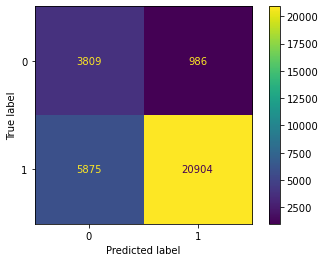

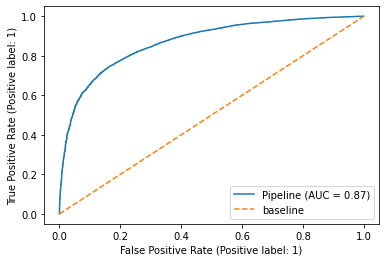

In [19]:
%%time
model = meta_func (
    model=Pipeline(
        [
            ('ss',StandardScaler()),
            ('lsvc', LinearSVC(class_weight='balanced'))
        ]
    ),
    model_name='lsvc_1st_round',
    param_grid=
{   'lsvc__max_iter':[500,1000],
    'lsvc__C': [0.001,0.01,0.1], 
    'lsvc__dual': [True, False],     
    'lsvc__penalty':['l1','l2']   
},
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    score_dict= score_dict_drivers
)

#### Checking our baseline models

In [20]:
drivers_score_df= pd.DataFrame(score_dict_drivers).T
drivers_score_df

,Train_acc,Test_acc,Train_recall,Test_recall,Train_preci,Test_preci,Train_f1score,Test_f1score,Train_roc_auc,Test_roc_auc,Train_specificity,Test_specificity
lr_1st_round,0.781204,0.781529,0.777731,0.778894,0.956113,0.955255,0.857746,0.858107,0.789168,0.787570,0.800605,0.796246
abc_1st_round,0.877003,0.873345,0.968623,0.967736,0.894997,0.892083,0.930356,0.928371,0.666943,0.656965,0.365262,0.346194
xgb_1st_round,0.880250,0.877209,0.965076,0.965122,0.900810,0.897770,0.931836,0.930228,0.685766,0.675679,0.406455,0.386236
lsvc_1st_round,0.782693,0.782701,0.779757,0.780612,0.955905,0.954957,0.858892,0.859027,0.789425,0.787490,0.799093,0.794369


### 3. Feature selection based on statistical significance - Hypothesis testing

Categorical - Continuous Split

In [21]:
df_driv.shape

(157870, 29)

In [22]:
df_driv['injury_level'] = df_driv['injury_level'].map({1:'OK',0:'not_ok'}) #Reverting target variable into categorical to fit to this template

In [23]:
# subsetting categorical and continuous features to run chi-square test
driv_cat = df_driv.select_dtypes(include=['object'])
driv_cont = df_driv.select_dtypes(include=['int64','float64'])

In [24]:
print(driv_cat.shape)
print(driv_cont.shape)

(157870, 24)
(157870, 5)


In [25]:
# subsetting continuous features to run anova/KS test
driv_cont.head(1)


,road_num,num_operating_lanes,month,hour,speed_group
0,0.0,10,11,1,4.0


In [26]:
# joining response variable, injury_level, into continuous features dataframe
injury_level_serie = driv_cat[['injury_level']]
driv_cont = driv_cont.join(injury_level_serie) #adding the injury to the continuous table
print(driv_cont.shape)
driv_cont.head()

(157870, 6)


,road_num,num_operating_lanes,month,hour,speed_group,injury_level
0,0.0,10,11,1,4.0,OK
2,0.0,10,11,1,4.0,OK
3,0.0,2,11,2,4.0,OK
4,0.0,8,11,15,5.0,OK
6,0.0,8,11,15,5.0,OK


#### Categorical features selection<br>
Pick statistically significant features

In [27]:
# label encoding for categorical features with more than 2 values
label_encoder = LabelEncoder()

cat_train_transformed_dict = {}

for col in driv_cat.columns:
    cat_train_transformed = label_encoder.fit_transform(driv_cat[col])
    cat_train_transformed_dict[col] = cat_train_transformed
    
cat_train_transformed = pd.DataFrame(cat_train_transformed_dict)
print(cat_train_transformed.shape)
cat_train_transformed.head()

(157870, 24)


,seat,injury_level,gender,safety_feat_1,navigation_direction,vehicule_type,impact_location,was_doing,engine_type,road_type,...,road_location_accident,light_conditions,in_out_city,crossing,weather,collision_type,day_of_week,event,vehi_grp,age_group
0,0,0,0,7,1,2,6,16,1,1,...,3,2,1,0,5,4,2,11,1,2
1,0,0,1,7,1,15,1,5,1,1,...,3,2,1,0,5,4,2,11,1,3
2,0,0,0,7,2,2,0,17,1,1,...,3,2,1,0,5,1,2,11,1,2
3,0,0,1,7,2,2,0,17,1,1,...,3,0,1,0,5,2,4,11,1,1
4,0,0,1,7,2,2,4,17,1,1,...,3,0,1,0,5,2,4,11,1,1


In [28]:
# chi-square test
X = cat_train_transformed.drop('injury_level',axis=1)
y = cat_train_transformed['injury_level']

chi_scores = chi2(X,y)

# top correlated features + p_values visualization from chi-square test
p_values = pd.Series(chi_scores[1],index = X.columns)
p_values.sort_values(inplace = True)

fig=px.bar(p_values, labels={'value': 'p_value'}, width=600, height=500)
fig.add_hline(y=0.05, line_dash="dash", line_color="red")
fig.update_layout(showlegend=False)
fig.update_xaxes(tickangle = 90)

In [29]:
# top correlated features + p_values converted to dataframe for top features list extraction
cat_pvals_df = pd.DataFrame(p_values, columns=['p_value'])
cat_pvals_df.sort_values(by = 'p_value',ascending=False).head(-5)

,p_value
age_group,1.206672e-01
event,8.922706e-02
weather,1.813359e-02
navigation_direction,2.378479e-03
engine_type,2.183114e-05
seat,5.141192e-07
day_of_week,1.107127e-08
road_surface,3.995913e-19
road_location_accident,1.096025e-23
light_conditions,5.586005e-30


In [30]:
# list of top correlated categorical features
top_cat_features_list = cat_pvals_df[cat_pvals_df['p_value']<0.05].index.to_list()
top_cat_features_list
print(len(top_cat_features_list))

21


We get our categorical features to include in our 2nd round

#### Continuous features selection
1. Pick non-correlated features
2. If 2 columns are correlated, pick the column with better statistical significance

In [31]:
# extracting all continuous feature column
driv_cont_columns = [col for col in driv_cont if col not in ['injury_level']]
print(len(driv_cont_columns))
driv_cont_columns

5


['road_num', 'num_operating_lanes', 'month', 'hour', 'speed_group']

In [32]:
# running normality and statistical significance tests on continuous features

results_dict = {col:cont_stat_sig_test(driv_cont,col) for col in driv_cont_columns}
cont_stat_results_df = pd.DataFrame.from_dict(results_dict, orient='index', columns=['p_value']).sort_values(by='p_value')

fig=px.bar(cont_stat_results_df, labels={'value': 'p_value'}, width=600, height=500)
fig.add_hline(y=0.05, line_dash="dash", line_color="red")
fig.update_layout(showlegend=False)
fig.update_xaxes(tickangle = 90)


road_num has non-normal distribution: running KS test. result: statistically significant
num_operating_lanes has non-normal distribution: running KS test. result: statistically significant
month has non-normal distribution: running KS test. result: statistically significant
hour has non-normal distribution: running KS test. result: statistically significant
speed_group has non-normal distribution: running KS test. result: statistically significant


All our continuous features are statistically significant in predicting severity of an accident

In [33]:
# rearranging driv_cont dataset's feature columns in the order of statistical significance
driv_cont = driv_cont[['injury_level']+cont_stat_results_df.index.tolist()]
cont_feature_cols = driv_cont.columns.tolist()
cont_feature_cols.remove('injury_level')
print(driv_cont.shape)
driv_cont.head()

(157870, 6)


,injury_level,road_num,num_operating_lanes,speed_group,hour,month
0,OK,0.0,10,4.0,1,11
2,OK,0.0,10,4.0,1,11
3,OK,0.0,2,4.0,2,11
4,OK,0.0,8,5.0,15,11
6,OK,0.0,8,5.0,15,11


In [34]:
# heatmap to visualize correlated features
pearson_corr_features = driv_cont.corr()
corr_data = np.tril(pearson_corr_features,k=-1)
corr_data = abs(corr_data)>0.90

fig = px.imshow(corr_data, x=pearson_corr_features.columns, y=pearson_corr_features.index,
                color_continuous_scale=px.colors.qualitative.Plotly, width=800, height=800,
                title="heat map: continuous feature correlations with >0.9 correlation coefficient")
fig.update(layout_coloraxis_showscale=False)
fig.show()


No correlation

In [35]:
# getting final list of features for modeling
# if 2 columns are correlated (yellow color), pick the column with better statistical significance
index_list = [idx for idx,row in enumerate(corr_data) if np.sum(row)>0]
print(index_list)

top_cont_feature_list = [col for idx, col in enumerate(cont_feature_cols) if idx not in index_list]
print(top_cont_feature_list)


[]
['road_num', 'num_operating_lanes', 'speed_group', 'hour', 'month']


### Model evaluation post features selection

In [36]:
train_feature_sel = df_driv[top_cont_feature_list + top_cat_features_list + ['injury_level']]
print(train_feature_sel.shape)
train_feature_sel.head()

(157870, 27)


,road_num,num_operating_lanes,speed_group,hour,month,vehi_grp,safety_feat_1,road_incline,vehicule_type,impact_location,...,road_type,light_conditions,road_location_accident,road_surface,day_of_week,seat,engine_type,navigation_direction,weather,injury_level
0,0.0,10,4.0,1,11,4_wheels,safety_belt,flat,car,rear_right,...,highway,night,road,normal,Saturday,driver,gas,postal_address_PK,normal,OK
2,0.0,10,4.0,1,11,4_wheels,safety_belt,flat,tractor,front_left,...,highway,night,road,normal,Saturday,driver,gas,postal_address_PK,normal,OK
3,0.0,2,4.0,2,11,4_wheels,safety_belt,hill_down,car,front,...,highway,night,road,normal,Saturday,driver,gas,postal_address_PR,normal,OK
4,0.0,8,5.0,15,11,4_wheels,safety_belt,flat,car,front,...,highway,bright_light,road,normal,Thursday,driver,gas,postal_address_PR,normal,OK
6,0.0,8,5.0,15,11,4_wheels,safety_belt,flat,car,rear,...,highway,bright_light,road,normal,Thursday,driver,gas,postal_address_PR,normal,OK


### 4. Rerunning models

In [37]:
#encoding
X = train_feature_sel.drop(columns='injury_level')
X = pd.get_dummies(X, columns=X.select_dtypes('object').columns, drop_first=True)
y=train_feature_sel[['injury_level']]
y['injury_level']= y['injury_level'].map({'OK':1,'not_ok':0})#remapping our variable of interest to a binary outcome
X_train,X_test,y_train,y_test = train_test_split(X, y,random_state=42, test_size=0.2, stratify=y)

#### Logistic Regression

In [38]:
ss = StandardScaler()
X_train_ss = ss.fit_transform(X_train) 
X_test_ss= ss.transform(X_test)

In [39]:
lr = LogisticRegression(random_state=42, solver='saga', penalty='l2', class_weight='balanced', C=0.2)

In [40]:
lr.fit(X_train_ss,y_train)

LogisticRegression(C=0.2, class_weight='balanced', random_state=42,
                   solver='saga')

In [41]:
preds = lr.predict(X_test_ss)
train_preds = lr.predict(X_train_ss)


best params : <bound method BaseEstimator.get_params of LogisticRegression(C=0.2, class_weight='balanced', random_state=42,
                   solver='saga')>
Test_f1_score : 0.855759922555663
Test_precision score : 0.9541613081021495
Test_accuracy score : 0.7782035852283524
Test_recall score : 0.7757571231188618
Test_roc_auc score : 0.7838118253759063


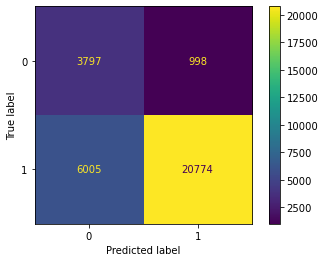

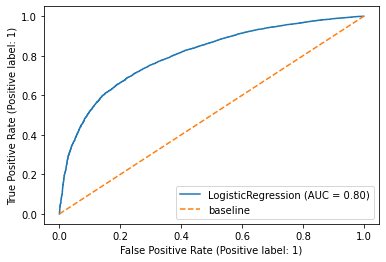

In [42]:
#getting the test metrics ready
test_f1score=f1_score(y_test,preds)
test_precision=precision_score(y_test,preds)
test_accuracy=accuracy_score(y_test,preds)
test_recall=recall_score(y_test,preds)
test_roc_auc=roc_auc_score(y_test,preds)
test_specificity = specificity_score(y_test,preds)

#getting the train metrics
train_f1score=f1_score(y_train,train_preds)
train_specificity = specificity_score(y_train,train_preds)
train_precision=precision_score(y_train,train_preds)
train_accuracy=accuracy_score(y_train,train_preds)
train_recall=recall_score(y_train,train_preds)
train_roc_auc=roc_auc_score(y_train,train_preds)
#printing results-----------------------------------------------------------------

print(f'best params : {lr.get_params}')

print(f'Test_f1_score : {test_f1score}')
print(f'Test_precision score : {test_precision}')
print(f'Test_accuracy score : {test_accuracy}')
print(f'Test_recall score : {test_recall}')
print(f'Test_roc_auc score : {test_roc_auc}')
        
# #update various metrics onto results list-------------------------------------------------------------
score_dict_drivers['lr_2nd_round'] = {
        'Train_acc':train_accuracy,
        'Test_acc':test_accuracy,
        'Train_recall':train_recall,
        'Test_recall':test_recall,
        'Train_preci':train_precision,
        'Test_preci':test_precision,
        'Train_f1score':train_f1score,
        'Test_f1score':test_f1score,
        'Train_roc_auc':train_roc_auc,
        'Test_roc_auc':test_roc_auc,
        'Train_specificity': train_specificity,
        'Test_specificity':test_specificity
        }

tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
cm = confusion_matrix(y_test,preds)
displ = ConfusionMatrixDisplay(cm)
displ.plot();

plot_roc_curve(lr, X_test, y_test)
plt.plot([0, 1], [0, 1],
label='baseline', linestyle='--') # to simulate random guess 
plt.legend();

In [43]:
pd_features = pd.DataFrame({'features_name':X_train.columns, 'coefs':lr.coef_[0]})
pd_features.sort_values(by='coefs', ascending=False)

,features_name,coefs
13,safety_feat_1_safety_belt,0.419224
67,was_doing_turning,0.326380
45,travelling_direction_unidirectional,0.278443
70,collision_type_three_or_more_vehicules_chain,0.249060
80,road_type_highway,0.227160
...,...,...
89,road_location_accident_others,-0.201329
10,safety_feat_1_helmet,-0.309034
43,in_out_city_out_of_city,-0.361171
91,road_location_accident_road_side,-0.386250


#### Adaboost

Fitting 3 folds for each of 4 candidates, totalling 12 fits
best params : {'learning_rate': 1, 'n_estimators': 300}
Test_f1_score : 0.928149923107185
Test_precision score : 0.8905054386988299
Test_accuracy score : 0.8727433964654463
Test_recall score : 0.9691175921430972
Test_roc_auc score : 0.6518163560298385
CPU times: total: 1min 20s
Wall time: 5min


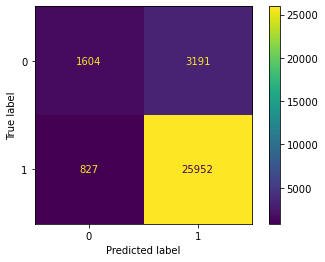

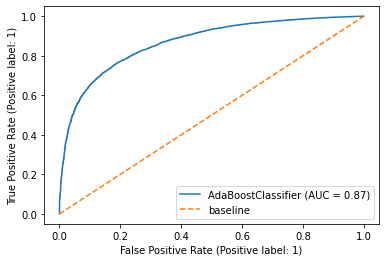

In [44]:
%%time
model = meta_func (
    model=AdaBoostClassifier(random_state=42)
,
    model_name='abc_2nd_round',
    param_grid=
{
    'n_estimators': [150,300], 
    'learning_rate': [1, 2]
    }
,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    score_dict= score_dict_drivers
)

In [45]:
pd_features = pd.DataFrame({'Features': X_train.columns,'Coef_': model.best_estimator_.feature_importances_})
pd_features.sort_values(by='Coef_', ascending=False)

,Features,Coef_
3,hour,0.110000
90,road_location_accident_road,0.076667
2,speed_group,0.070000
91,road_location_accident_road_side,0.063333
1,num_operating_lanes,0.046667
...,...,...
94,road_surface_muddy,0.000000
95,road_surface_normal,0.000000
97,road_surface_others,0.000000
98,road_surface_snow_ice,0.000000


#### XGBoost

Fitting 3 folds for each of 8 candidates, totalling 24 fits
best params : {'learning_rate': 0.5, 'max_depth': 3, 'min_split_loss': 2}
Test_f1_score : 0.9297324510932106
Test_precision score : 0.896556507264972
Test_accuracy score : 0.8762272756065117
Test_recall score : 0.9654580081407073
Test_roc_auc score : 0.6716758236741075
CPU times: total: 1min 20s
Wall time: 2min 49s


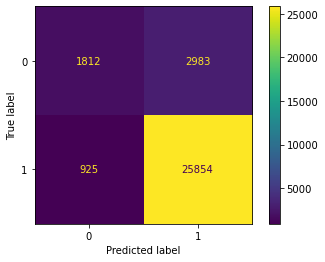

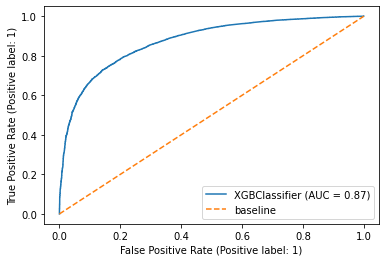

In [46]:
%%time
model = meta_func (
    model=XGBClassifier(random_state=42)
,
    model_name='xgb_2nd_round',
    param_grid=
{
    'learning_rate': [0.5,1], 
    'min_split_loss': [1,2], #The larger gamma is, the more conservative the algorithm will be
    'max_depth':[2,3] #Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit.
     # Beware that XGBoost aggressively consumes memory when training a deep tree
    }
,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    score_dict= score_dict_drivers
)

In [47]:
pd_features = pd.DataFrame({'Features': X_train.columns,'Coef_': model.best_estimator_.feature_importances_})
pd_features.sort_values(by='Coef_', ascending=False)

,Features,Coef_
13,safety_feat_1_safety_belt,0.206050
83,road_type_regional_rd,0.114867
91,road_location_accident_road_side,0.064915
43,in_out_city_out_of_city,0.053323
45,travelling_direction_unidirectional,0.038549
...,...,...
84,road_type_unpaved_rd,0.000000
99,road_surface_water_patches,0.000000
97,road_surface_others,0.000000
96,road_surface_oily_slippery,0.000000


#### Linear Support Vectors Classifiers

Fitting 3 folds for each of 24 candidates, totalling 72 fits
best params : {'lsvc__C': 0.1, 'lsvc__dual': True, 'lsvc__max_iter': 500, 'lsvc__penalty': 'l2'}
Test_f1_score : 0.8557246720079089
Test_precision score : 0.9540736658399926
Test_accuracy score : 0.7781402419712422
Test_recall score : 0.7757571231188618
Test_roc_auc score : 0.7836032748023923
CPU times: total: 34.4 s
Wall time: 8min 59s


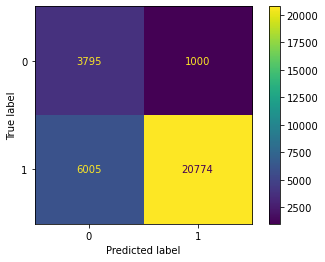

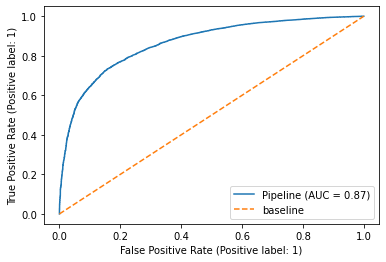

In [48]:
%%time
model = meta_func (
    model=Pipeline(
        [
            ('ss',StandardScaler()),
            ('lsvc', LinearSVC(class_weight='balanced'))
        ]
    ),
    model_name='lsvc_2nd_round',
    param_grid=
{   'lsvc__max_iter':[500,1000],
    'lsvc__C': [0.001,0.01,0.1], 
    'lsvc__dual': [True, False],     
    'lsvc__penalty':['l1','l2']   
},
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    score_dict= score_dict_drivers
)

In [49]:
pd_features = pd.DataFrame({'Features': X_train.columns,'Coef_': model.best_estimator_.steps[-1][1].coef_[0]})
pd_features.sort_values(by='Coef_', ascending=False)

,Features,Coef_
13,safety_feat_1_safety_belt,0.240355
85,road_type_urban_rd,0.238185
80,road_type_highway,0.232772
67,was_doing_turning,0.145626
83,road_type_regional_rd,0.130299
...,...,...
90,road_location_accident_road,-0.076873
89,road_location_accident_others,-0.077731
43,in_out_city_out_of_city,-0.127251
91,road_location_accident_road_side,-0.148060


In [50]:
drivers_score_df= pd.DataFrame(score_dict_drivers).T
drivers_score_df.sort_values(by= 'Test_specificity', ascending=False)

,Train_acc,Test_acc,Train_recall,Test_recall,Train_preci,Test_preci,Train_f1score,Test_f1score,Train_roc_auc,Test_roc_auc,Train_specificity,Test_specificity
lr_1st_round,0.781204,0.781529,0.777731,0.778894,0.956113,0.955255,0.857746,0.858107,0.789168,0.787570,0.800605,0.796246
lsvc_1st_round,0.782693,0.782701,0.779757,0.780612,0.955905,0.954957,0.858892,0.859027,0.789425,0.787490,0.799093,0.794369
lr_2nd_round,0.778409,0.778204,0.774566,0.775757,0.955787,0.954161,0.855687,0.855760,0.787221,0.783812,0.799875,0.791867
lsvc_2nd_round,0.779051,0.778140,0.775808,0.775757,0.955284,0.954074,0.856242,0.855725,0.786486,0.783603,0.797163,0.791449
xgb_1st_round,0.880250,0.877209,0.965076,0.965122,0.900810,0.897770,0.931836,0.930228,0.685766,0.675679,0.406455,0.386236
xgb_2nd_round,0.880701,0.876227,0.966327,0.965458,0.900323,0.896557,0.932158,0.929732,0.684384,0.671676,0.402440,0.377894
abc_1st_round,0.877003,0.873345,0.968623,0.967736,0.894997,0.892083,0.930356,0.928371,0.666943,0.656965,0.365262,0.346194
abc_2nd_round,0.875404,0.872743,0.968950,0.969118,0.893203,0.890505,0.929536,0.928150,0.660927,0.651816,0.352904,0.334515


In [51]:
#exporting scoring file to AWS S3
bucket = aws_creds.bucket # already created on S3
csv_buffer = StringIO()
drivers_score_df.to_csv(csv_buffer)
s3_resource = boto3.resource('s3')
s3_resource.Object(bucket, 'drivers_scores.csv').put(Body=csv_buffer.getvalue()) # exporting the dataframe

{'ResponseMetadata': {'RequestId': 'YACGQ90SJ55YRCRV',
  'HostId': 'jygLG7GVJeK6bDu/6dJxQS0l1Tdj0aqRTNbIX1/pQHXT3cV3p4kFqwwIhcySqWQaqUZlxb2lcX8=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'jygLG7GVJeK6bDu/6dJxQS0l1Tdj0aqRTNbIX1/pQHXT3cV3p4kFqwwIhcySqWQaqUZlxb2lcX8=',
   'x-amz-request-id': 'YACGQ90SJ55YRCRV',
   'date': 'Thu, 08 Dec 2022 09:29:26 GMT',
   'etag': '"f584968528bd3d56e03e45a81872893d"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 1},
 'ETag': '"f584968528bd3d56e03e45a81872893d"'}

In [52]:
et = time.time() # end time
elapsed_time = et - st
print('Execution time:', elapsed_time/60, 'minutes')

Execution time: 36.5991930603981 minutes
